# Evaluation of WRF-Chem with GEos-Chem

In [1]:
#import modules
from load_main import *
import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import aerosols_202 as aer

### Load model data

In [2]:
#Get data for each season
post_pth='/geos/d21/s1878599/IGP/outputs/autumn/base2/wrfout*'
win_pth='/geos/d21/s1878599/IGP/outputs/winter/base2/wrfout*.nc'
mon_pth='/geos/d21/s1878599/IGP/outputs/monsoon/base2/wrfout*.nc'
pre_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/base2/wrfout*.nc'

pth_d={"pre":pre_pth,"mon":mon_pth,"post":post_pth,"win":win_pth}

s=utl.dictdata(pth_d)

In [3]:
# Rain production
def calc_totrain(ds):
    # following formula userguide v4 
    bucket_mm=100
    ds["RAINTOT"]=(ds.RAINC + bucket_mm*ds.I_RAINC) + (ds.RAINNC + bucket_mm*ds.I_RAINNC)
    ds["RAINTOT"]=ds["RAINTOT"][len(ds.Time)-1,:,:] #get only lsat value (accumulated)
    
for v in s.values():
        calc_totrain(v)

In [4]:
# get geos-chem data
gc_pth='/geos/d21/mmarvin/for_cate/geoschem_output_2017.nc'
gc=xr.open_mfdataset(gc_pth)

In [5]:
# regrid meteo data on model grid
new_lon = s["mon"]['XLONG'][0,0,:].values
new_lat = s["mon"]['XLAT'][0,:,0].values

gc_igp =gc.interp(lon=new_lon, lat=new_lat, method='nearest')

In [6]:
#select seasons
gc_pre = gc_igp.sel(time=slice('2017-04-01T00:00:00.000000000','2017-05-01T00:00:00.000000000')).mean("time")
gc_mon = gc_igp.sel(time=slice('2017-06-01T00:00:00.000000000','2017-07-01T00:00:00.000000000')).mean("time")
gc_post = gc_igp.sel(time=slice('2017-10-01T00:00:00.000000000','2017-11-01T00:00:00.000000000')).mean("time")
gc_win = gc_igp.sel(time=slice('2017-01-01T00:00:00.000000000','2017-02-01T00:00:00.000000000')).mean("time")

gcs={"pre":gc_pre,"mon":gc_mon,"post":gc_post,"win":gc_win}

In [7]:
#get aerosols for wrf-chem
a_wf={}
for k in s.keys():
    a_wf.update({k: aer.get_aerosols(s[k])})

In [8]:
# Get seasonal values
for k in s.keys():
    s[k]=s[k].mean("Time")
    a_wf[k]=a_wf[k].mean("Time")

In [9]:
# Get only relevant variables

lats=gcs["mon"].lat
lons=gcs["mon"].lon
coords={'lat': (['lat'],lats), 'lon': (['lon'], lons)}

ds_gc={}
for k,v in gcs.items():
    data ={"PM25" : (["lat","lon"], v.IJ_SOA_S_PM25.values[0,:,:]),
           "POA" : (["lat","lon"], v.IJ_SOA_S_POA.values[0,:,:]),
           "SOA" : (["lat","lon"], (v.IJ_SOA_S_TSOA +v.IJ_SOA_S_ISOA+v.IJ_SOA_S_ASOA).values[0,:,:]),
           "NO" : (["lat","lon"], v.IJ_AVG_S_NO.values[0,:,:]),
           "NO2" : (["lat","lon"], v.IJ_AVG_S_NO2.values[0,:,:]),
           "CO" : (["lat","lon"], v.IJ_AVG_S_CO.values[0,:,:])
          }
    ds = xr.Dataset(data, coords=coords,attrs=s[k].attrs)
    ds_gc.update({k:ds})


ds_wf={}
for k in s.keys():
    data ={"PM25" : (["lat","lon"], a_wf[k].pm25_tot.values[0,:,:]),
           "POA" : (["lat","lon"], a_wf[k].pm10_POA.values[0,:,:]),
           "SOA" : (["lat","lon"], a_wf[k].pm10_SOA.values[0,:,:]),
           "NO" : (["lat","lon"], s[k].no.values[0,:,:]),
           "NO2" : (["lat","lon"], s[k].no2.values[0,:,:]),
           "CO" : (["lat","lon"], s[k].co.values[0,:,:])
           }
    ds = xr.Dataset(data, coords=coords,attrs=s[k].attrs)
    ds_wf.update({k:ds})

In [10]:
# shape files for IGP
import salem
shdf= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp")

for k in s.keys():
    ds_wf[k]= ds_wf[k].salem.roi(shape=shdf)
    ds_gc[k]= ds_gc[k].salem.roi(shape=shdf)

## Plot

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [20]:
lat=gcs["mon"].lat.values
lon=gcs["mon"].lon.values

def plot_compare(lat,lon,mod,obs,var,label="",vmin=0,vmax=100,vmin_d=-200,vmax_d=200):
    
    fig, axes =plt.subplots(nrows=3,ncols=4,figsize=[16,10],sharey=True,sharex=True)

    for ax in fig.axes:
        ax.grid()

    levels = np.linspace(vmin, vmax, 20)  
    levels_d = np.linspace(vmin_d,vmax_d, 20)
    
    for k,i in zip(mod.keys(),np.arange(0,len(mod))):
     
    
        mo=mod[k][var].values
        st=obs[k][var].values
        d=(mo-st)
    
        a=axes[0,i].contourf(lon,lat,mo,cmap="jet",levels=levels,extend="both")
        b=axes[1,i].contourf(lon,lat,st,cmap="jet",levels=levels,extend="both")
        c=axes[2,i].contourf(lon,lat,d,cmap="bwr",levels=levels_d,extend="both", 
                         norm=MidpointNormalize(vmin=vmin_d,vmax=vmax_d,midpoint=0))
        a.cmap.set_under('#00008B')
        a.cmap.set_over("#800000")
        b.cmap.set_under('#00008B')
        b.cmap.set_over("#800000")
        c.cmap.set_under('#00008B')
        c.cmap.set_over("#800000")
    
        axes[0,i].set_title(k)

    fig.subplots_adjust(right=0.5) 
    cbar_ax1 = fig.add_axes([1, 0.4, 0.01, 0.5]) 
    cbar_ax2 = fig.add_axes([1, 0.035, 0.01, 0.3]) 
    cbar1 = fig.colorbar(a, cax=cbar_ax1,format="%.f",extend="both",label=label)
    cbar3 = fig.colorbar(c, cax=cbar_ax2,format="%.1f",extend="both",label=label)  
    

    axes[0,0].text(-0.2, 0.55, "WRF-CHEM", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[0,0].transAxes)
    axes[1,0].text(-0.2, 0.55, "GEOS-CHEM 4x5", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[1,0].transAxes)
    axes[2,0].text(-0.2, 0.55, "DIFFERENCE", va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[2,0].transAxes)    

    plt.tight_layout()
    
    fig.show()

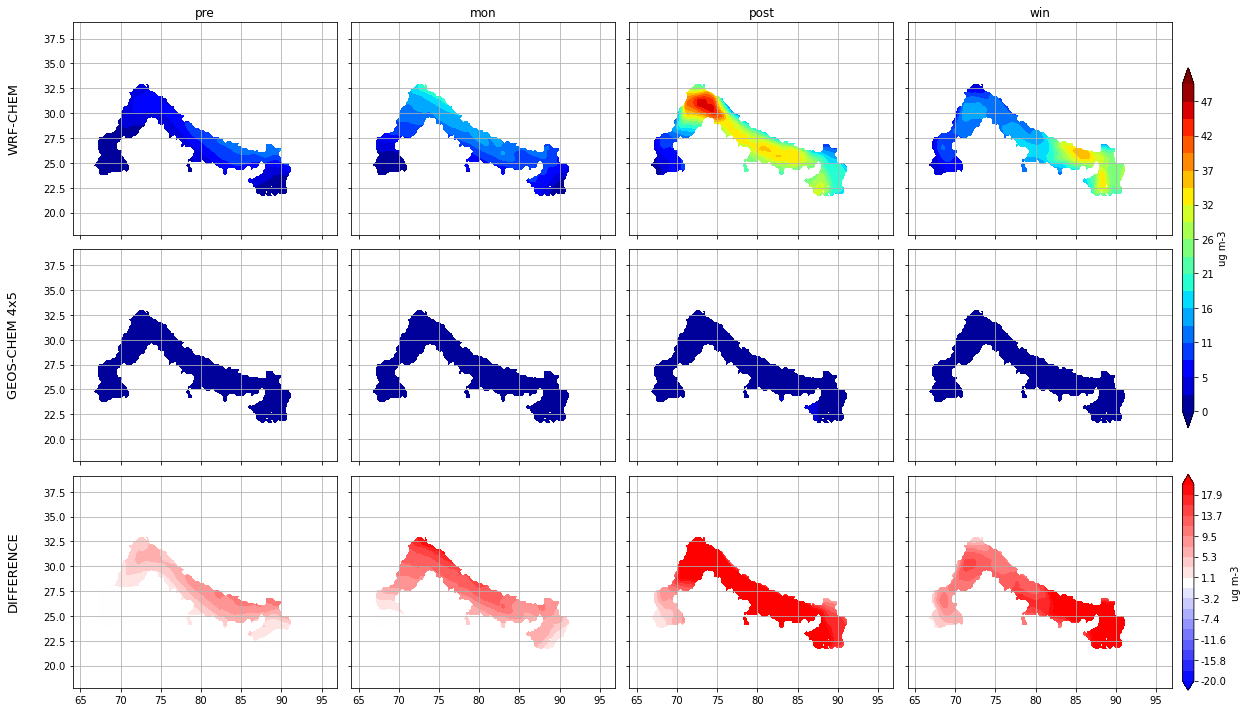

In [29]:
plot_compare(lat,lon,ds_wf,ds_gc,"SOA",label="ug m-3",vmin=0,vmax=50,vmin_d=-20,vmax_d=+20)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats.mstats as ss
#def plot_scatter(ds,metr,sp,xtitle,ytitle,f=0.1):

f=1
xd=ds_met["win"]["T"].values.flatten()
xd=xd[~np.isnan(xd)]
yd=ds_mod["win"]["T"].values.flatten()
yd=yd[~np.isnan(yd)]

#points
fig=go.Figure()
fig.add_trace(
        go.Scatter(x=xd, y=yd,mode='markers', marker_line_width=1.5,showlegend=False))
#fig = px.scatter(ds, x=xd, y=yd)
#fig.update_traces(mode='markers', marker_line_width=1.5)

#guide lines
maxi=max(xd.max(),yd.max())
x = np.linspace(0,maxi+maxi*0.15,15)
lines=[[x,x],[x,0.5*x]]
lab=["y=x","y=0.5x"]
    
for v,l in zip(lines,lab):
    fig.add_trace(
        go.Scatter(
        x=v[0],
        y=v[1],
        mode="lines+text",
        line=go.scatter.Line(color="gray",width=0.7),
        showlegend=False,
        text=["","","","","","","","","","","","","",l,""],
        textposition="top left",
        textfont=dict(
        family="sans serif",
        size=16,
        color="gray"
        ),
        )
        )
        
        #add 2x label
x1 = np.linspace(0,maxi+maxi*f,40)
fig.add_trace(
        go.Scatter(
        x=x1,
        y=2*x1,
        mode="lines+text",
        line=go.scatter.Line(color="gray",width=0.7),
        showlegend=False,
        text=["","","","","","","","","","","y=2x","",""],
        textposition="bottom right",
        textfont=dict(
        family="sans serif",
        size=14,
        color="gray"
        ),
        )
        )

#best fit
m, q, r, p, std  =ss.linregress(xd,yd)   
print(m)
    #gradient
fig.add_trace(
        go.Scatter(
        x=x,
        y=m*x+q,
        mode="lines",
        line=go.scatter.Line(color="orange",width=1),
        showlegend=False,
        ),
        )
        
    # add r value
fig.add_annotation(
        x=0.03,
        y=0.95,
        xref="paper",
        yref="paper",
        text="r="+ str(round(r,2)) +"<br>"+
             "best fit: y="+str(round(m,2)) +"x + "+ str(round(q,3)),
        showarrow=False,
        font=dict(
            size=14,
            color="black"
        ),
        align="left",
        bgcolor="White",
        bordercolor="Black",
        borderwidth=1
        )

fig.update_xaxes(range= [280,320])#[0-maxi*0.05, maxi+maxi*0.15])
fig.update_yaxes(range= [280,320])  #[0-maxi*0.05, maxi+maxi*0.15])
fig.update_layout(
    width = 600,
    height = 600,
    xaxis=dict(title="GMAO T(K)"),
    yaxis = dict(
      scaleanchor = "x",
      scaleratio = 1,
      title="WRF-Chem T (k)")
    )

fig.update_layout(title_text="WINTER",title_x=0.5)

fig.show()